 # Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 
У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# Описание данных

id — уникальный идентификатор сотрудника;  
dept — отдел, в котором работает сотрудник;  
level — уровень занимаемой должности;  
workload — уровень загруженности сотрудника;  
employment_years — длительность работы в компании (в годах);  
last_year_promo — показывает, было ли повышение за последний год;  
last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;  
supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;  
salary — ежемесячная зарплата сотрудника;  
job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.   
quit — увольнение сотрудника из компании.

# Импорт необходимых библиотек

In [1]:
!pip install phik 
!pip install shap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

import sklearn

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree 
from sklearn.svm import SVR

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from warnings import simplefilter

from sklearn.metrics import make_scorer
import shap

from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [3]:
try:
    X_y_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
    X_test = pd.read_csv('/datasets/test_features.csv')
except:
    X_y_train = pd.read_csv(r'C:\Users\User\Downloads\train_job_satisfaction_rate.csv')
    y_test = pd.read_csv(r'C:\Users\User\Downloads\test_target_job_satisfaction_rate.csv')
    X_test = pd.read_csv(r'C:\Users\User\Downloads\test_features.csv')

X_y_train = X_y_train.set_index('id')
y_test = y_test.set_index('id')
X_test = X_test.set_index('id')

X_train = X_y_train.drop(['job_satisfaction_rate'], axis=1)
y_train = X_y_train['job_satisfaction_rate']

y_train = y_train.to_frame(name='job_satisfaction_rate')

### Предобработка данных

In [4]:
X_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000
653870,hr,junior,high,2,no,no,5,38400
184592,sales,junior,low,1,no,no,2,12000
171431,technology,junior,low,4,no,no,2,18000
693419,hr,junior,medium,1,no,no,3,22800


In [5]:
X_test['dept'].value_counts()

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

замечен пробел, удалим его

In [6]:
X_test['dept'] = X_test['dept'].str.replace(' ', X_test['dept'].mode()[0])

In [7]:
X_test['workload'].value_counts()

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

замечен пробел, удалим его

In [8]:
X_test['workload'] = X_test['workload'].str.replace(' ', X_test['workload'].mode()[0])

In [9]:
df_test = X_test.merge(y_test, on='id', how='left')

X_test = df_test.drop([ 'job_satisfaction_rate'], axis=1)
y_test = df_test['job_satisfaction_rate']

In [10]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


In [11]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1)
memory usage: 62.5 KB


#### Вывод

Особых проблем в данных обнаружено не было. Данных достаточно для исследования. Явные и неявные дубликаты отсутсвуют, аномалий обнаружено не было. Были замечены пропуски, которые мы удалили вунтри пайплайна.

### Исследовательский анализ данных

Объеденим тестовую и тренировочную выборку для анализа

In [12]:
frames = [X_train, X_test]
X_data = pd.concat(frames)

In [13]:
X_data['dept'] = X_data['dept'].fillna(X_data['dept'].mode()[0])
X_data['level'] = X_data['level'].fillna(X_data['level'].mode()[0])

In [14]:
X_data.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000
653870,hr,junior,high,2,no,no,5,38400
184592,sales,junior,low,1,no,no,2,12000
171431,technology,junior,low,4,no,no,2,18000
693419,hr,junior,medium,1,no,no,3,22800


#### dept

count      6000
unique        5
top       sales
freq       2284
Name: dept, dtype: object


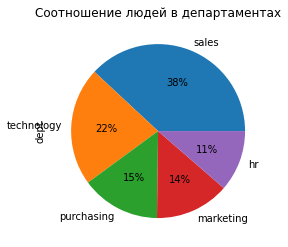

In [15]:
X_data['dept'].value_counts().plot(kind='pie', autopct='%1.0f%%')
print(X_data['dept'].describe())
plt.title("Соотношение людей в департаментах")
None

Самый большое департамент - saler, самый маленькие - HR.

#### level

count       6000
unique         3
top       junior
freq        2873
Name: level, dtype: object


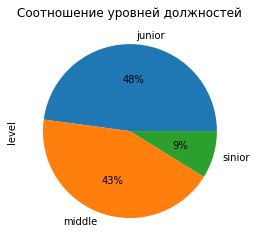

In [16]:
X_data['level'].value_counts().plot(kind='pie', autopct='%1.0f%%')
print(X_data['level'].describe())
plt.title("Соотношение уровней должностей")
None

Джунов немного больше чем мидлов, и гораздо больше чем сеньоров. 

#### workload

count       6000
unique         3
top       medium
freq        3110
Name: workload, dtype: object


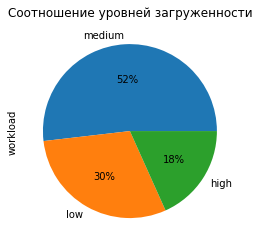

In [17]:
X_data['workload'].value_counts().plot(kind='pie', autopct='%1.0f%%')
print(X_data['workload'].describe())
plt.title("Соотношение уровней загруженности")
None

Тех кто загружен средне - примерно половина от общего числа сотрудников. Тех кто загружен мало примерно в 2 раза больше загруженных сильно.

#### employment_years

count    6000.000000
mean        3.701167
std         2.540658
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


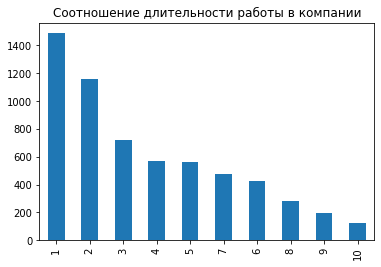

In [18]:
X_data['employment_years'].value_counts().plot(kind='bar')
print(X_data['employment_years'].describe())
plt.title("Соотношение длительности работы в компании")
None

Тут все выглядит абсолютно логичным

#### last_year_promo

count     6000
unique       2
top         no
freq      5817
Name: last_year_promo, dtype: object


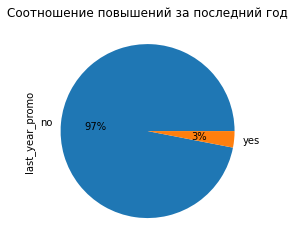

In [19]:
X_data['last_year_promo'].value_counts().plot(kind='pie', autopct='%1.0f%%')
print(X_data['last_year_promo'].describe())
plt.title("Соотношение повышений за последний год")
None

Как мы видим, всего у 3 процентов служащих были повышения за последний год.

#### last_year_violations

count     6000
unique       2
top         no
freq      5179
Name: last_year_violations, dtype: object


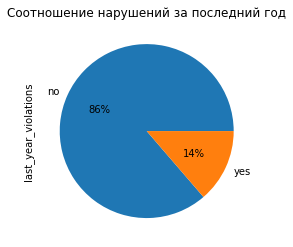

In [20]:
X_data['last_year_violations'].value_counts().plot(kind='pie', autopct='%1.0f%%')
print(X_data['last_year_violations'].describe())
plt.title("Соотношение нарушений за последний год")
None

А вот нарушали договор целых 14 процентов сотрудников.

#### supervisor_evaluation

count    6000.000000
mean        3.493167
std         1.005048
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


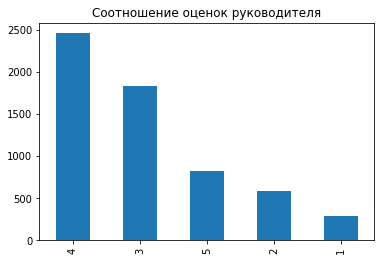

In [21]:
X_data['supervisor_evaluation'].value_counts().plot(kind='bar')
print(X_data['supervisor_evaluation'].describe())
plt.title("Соотношение оценок руководителя")
None

Распределение похоже на школьное: Больше всего четверок и троек, поменьше отличников, а двойки и единицы руководитель почти не ставит

#### salary

count     6000.000000
mean     33973.400000
std      15067.302669
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64


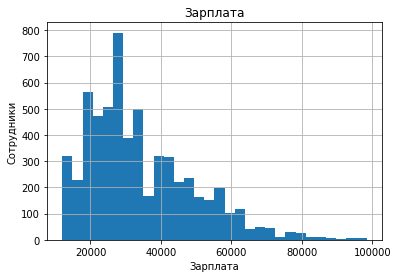

In [22]:
X_data['salary'].hist(bins=30)
print(X_data['salary'].describe())
plt.title("Зарплата")
plt.ylabel("Сотрудники")
plt.xlabel("Зарплата")
None

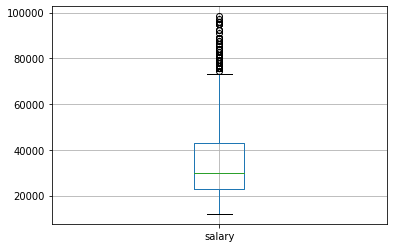

In [23]:
X_data.boxplot(column='salary')
None

Присутсвуют некоторые выбросы, однако они присутсвуют в датафрейме объединеной тестовой и тренировочной выборок, поэтому удалять их будет ненадежно

В целом распредение выглядит адекватным, что может говорить о достоверности данных.

#### job_satisfaction_rate

In [24]:
frames_y = [y_train, y_test]
y_data = pd.concat(frames_y)

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


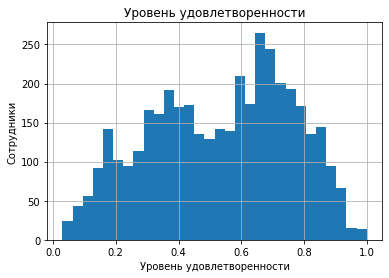

In [25]:
y_data['job_satisfaction_rate'].hist(bins=30)
print(y_data['job_satisfaction_rate'].describe())
plt.title("Уровень удовлетворенности")
plt.ylabel("Сотрудники")
plt.xlabel("Уровень удовлетворенности")
None

Распределение похоже на нормальное, что говорит о его достоверности

#### Вывод

Выбросы удалять не стал так как данные были разделены на тестовую и тренировочную выборку заказчиком, в остальном данные выглядят адекватными

###  Подготовка данных

In [26]:
ohe_columns = [ 
    'dept', 
    'last_year_promo',
    'last_year_violations'
]

num_columns = ['employment_years', 
               'salary','supervisor_evaluation']

ord_columns = ['level', 'workload']



In [27]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [28]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

### Обучение моделей

In [29]:
def smape(y_pred, y_true):
     return (1/len(y_true)) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))*100)

smare_scorer = make_scorer(smape, greater_is_better=False)

In [30]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=42))
    ]
) 

In [31]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=42)],
        'models__max_depth': range(1, 20),
        'models__min_samples_split': range(2, 20),
        'models__min_samples_leaf': range(1, 20),
    },

    # словарь для модели LinearRegression()
   {
       'models': [LinearRegression()], 
   },
        # словарь для модели SVC()
    
   {
       'models': [SVR()],
       'models__C': range(1, 20),
        'models__degree': range(1, 10) 
   }
]

In [32]:
simplefilter(action='ignore', category=FutureWarning)

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    cv=5,
    scoring=smare_scorer,
    random_state=42
    
)
randomized_search.fit(X_train, y_train.values.ravel())

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                              

In [33]:
#sorted(sklearn.metrics.SCORERS.keys())

In [34]:
randomized_search.best_score_

-14.76307217398267

In [35]:
y_test_pred = randomized_search.predict(X_test)
print(smape(np.array(y_test.values.ravel()), np.array(y_test_pred)))

13.281863784451325


### Лучшая модель

In [36]:
pipe_best_model = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(max_depth=16, min_samples_leaf=4,
                                       min_samples_split=9, random_state=42))
    ]
) 

In [40]:
X_train_get = pd.DataFrame(data_preprocessor.fit_transform(X_train))
X_test_get = pd.DataFrame(data_preprocessor.transform(X_test))

columns_names = (pipe_best_model['preprocessor'].transformers_[0][1][1].get_feature_names(ohe_columns)).tolist() + (ord_columns)+ (num_columns)

X_train_get.columns = [columns_names]
X_test_get.columns = [columns_names]

In [41]:
pipe_best_model.named_steps['models'].fit(X_train_get, y_train.values.ravel())

DecisionTreeRegressor(max_depth=16, min_samples_leaf=4, min_samples_split=9,
                      random_state=42)

In [42]:
smape(pipe_best_model.named_steps['models'].predict(X_test_get), y_test.values.ravel())

13.281863784451325

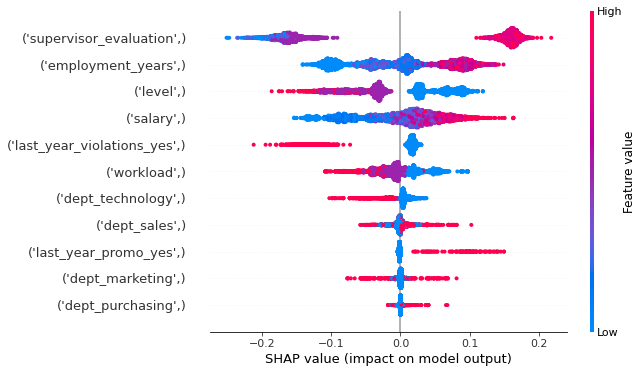

In [43]:
explainer = shap.TreeExplainer(pipe_best_model.named_steps['models'], X_train_get)
shap_values = explainer(X_train_get)

shap.plots.beeswarm(shap_values, max_display=25) 

### Вывод

На тестовой выборке лучший результат составил 13.28%. Лучше всего с задачей справилась модель Дерева решений, думаю это связано с тем, что категориальных признаков больше чем количественных, а в таких условиях дерево себя показывает с наилучшей стороны.

## Задача 2: предсказание увольнения сотрудника из компании

### Загрузка данных

In [44]:
try:
    X_y_train_2 = pd.read_csv('/datasets/train_quit.csv')
    y_test_2 = pd.read_csv('/datasets/test_target_quit.csv')
    X_test_2 = pd.read_csv('/datasets/test_features.csv')
except:
    X_y_train_2 = pd.read_csv(r'C:\Users\User\Downloads\train_quit.csv')
    y_test_2 = pd.read_csv(r'C:\Users\User\Downloads\test_target_quit.csv')
    X_test_2 = pd.read_csv(r'C:\Users\User\Downloads\test_features.csv')
    
X_y_train_2 = X_y_train_2.set_index('id')
y_test_2 = y_test_2.set_index('id')
X_test_2 = X_test_2.set_index('id')

X_train_2 = X_y_train_2.drop(['quit'], axis=1)
y_train_2 = X_y_train_2['quit']

y_train_2 = y_train_2.to_frame(name='quit')

X_test_2 = X_test

### Исследовательский анализ данных

Объеденим датасеты по индексу с обоими целевыми признаками. Так как индксы совпадают только в тестовой части, будем работать только с ней. Но даже так у нас получается 2000 полей, что достаточно для анализа.

In [45]:

frames = [X_train_2, X_test_2]
X_data = pd.concat(frames)
frames_y = [y_train_2, y_test_2]
y_data = pd.concat(frames_y)

pred_data = randomized_search.best_estimator_.predict(X_data)

X_data['job_satisfaction_rate'] = pred_data

In [46]:
data_iad = X_data.join(y_data, on='id')
data_iad.tail()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
393147,marketing,junior,low,3,no,no,3,20400,0.538571,yes
109582,technology,middle,low,3,no,no,2,21600,0.152000,yes
305653,technology,junior,low,1,no,no,3,14400,0.170000,yes
160233,technology,middle,low,8,no,no,1,32400,0.518571,no
771859,purchasing,middle,medium,1,no,no,4,38400,0.528000,no


#### Средняя удовлетворенность по департаментам

In [47]:
job_satisfaction_rate_by_dept = data_iad.groupby(['dept'])['job_satisfaction_rate'].mean().reset_index()
job_satisfaction_rate_by_dept

,dept,job_satisfaction_rate
0,hr,0.545627
1,marketing,0.558899
2,purchasing,0.526607
3,sales,0.542764
4,technology,0.536164


Видно, что в отделе продаж люди немного довольнее чем в остальных, однако разница небольшая. Самые неудовлетворенные люди в отделе технологий, однако разница меньше трех процентов.

In [48]:
quit_by_dept = data_iad.query("quit == 'yes'").groupby(['dept'])['quit'].count().reset_index()
quit_by_dept

,dept,quit
0,hr,181
1,marketing,230
2,purchasing,244
3,sales,633
4,technology,403


Посмотри на сводную таблицу по департаментам, увольнению и удовлетворенности

In [49]:
data_iad.pivot_table(index=['dept','quit'], values='job_satisfaction_rate', aggfunc=['mean', 'count'])

mean                 count
                job_satisfaction_rate job_satisfaction_rate
dept       quit                                            
hr         no                0.595446                   510
           yes               0.405253                   181
marketing  no                0.613561                   631
           yes               0.408935                   230
purchasing no                0.579400                   617
           yes               0.393112                   244
sales      no                0.598459                  1569
           yes               0.404714                   633
technology no                0.595980                   980
           yes               0.390705                   403

Видно, во всех департаментах, люди которые увольняются имеют гораздо более низкий уровень удовлетворенности

Самая дольшая разница в отделе маркетинга.

Теперь посмотреим на загруженность

In [50]:
data_iad.pivot_table(index=['workload','quit'], values='job_satisfaction_rate', aggfunc=['mean', 'count'])

mean                 count
              job_satisfaction_rate job_satisfaction_rate
workload quit                                            
high     no                0.579683                   841
         yes               0.465409                   196
low      no                0.618042                  1045
         yes               0.418178                   756
medium   no                0.593996                  2422
         yes               0.364572                   740

По таблице видно, что чем выше загруженность, тем меньше в процентом соотношение уволившихся сотрудников. Думаю это связано с тем, что более загруженные сотрудники довольны своей запрлатой, а те кто загружен меньше соотвественно получают меньше и меньше удовлетворены

Посмотрим среднюю зарплату тех кто остался и тех кто уволился.

In [51]:
data_iad.pivot_table(index=['quit'], values='salary', aggfunc='mean')

,salary
quit,
no,37683.286908
yes,24241.843972


Эта таблица подтверждает вывод из предыдущей. Чем меньше зарплата, тем более удовлетворенный сотрудник. Разница практически в полтора раз.

#### Вывод

Отдел в котором работает сотрудник практически никак не влияет на то уволится он или нет. Главное это зарплата. Те кто работают меньше, а соответственно и получают меньше менее удовлетворены своей работой, а значит и с большей вероятностью покинут свое рабочее место

###  Добавление нового входного признака

Как мы выяснили из предыдущего пункта, job_satisfaction_rate и quit действительно связаны, также у меня получилось достигнуть необходимого уровня метрики, добавим новую фичу.

In [52]:
X_train_2

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000
814010,sales,junior,medium,2,no,no,4,27600
155091,purchasing,middle,medium,5,no,no,1,37200
257132,sales,junior,medium,2,no,yes,3,24000
910140,marketing,junior,medium,2,no,no,5,25200
...,...,...,...,...,...,...,...,...
588809,sales,junior,medium,4,no,no,3,26400
672059,sales,middle,high,9,no,no,4,52800
536432,purchasing,junior,low,2,no,yes,4,12000


In [53]:
df_test = X_test_2.merge(y_test_2, on='id', how='left')

X_test_2 = df_test.drop([ 'quit'], axis=1)
y_test_2 = df_test['quit']


In [54]:
train_new = randomized_search.best_estimator_.predict(X_train_2)
test_new = randomized_search.best_estimator_.predict(X_test_2)

In [55]:
X_train_2['pred_job_satisfaction_rate'] = train_new
X_test_2['pred_job_satisfaction_rate'] = test_new

### Подготовка данных

In [56]:
X_train_2

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,pred_job_satisfaction_rate
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.626667
814010,sales,junior,medium,2,no,no,4,27600,0.821905
155091,purchasing,middle,medium,5,no,no,1,37200,0.332500
257132,sales,junior,medium,2,no,yes,3,24000,0.350000
910140,marketing,junior,medium,2,no,no,5,25200,0.812500
...,...,...,...,...,...,...,...,...,...
588809,sales,junior,medium,4,no,no,3,26400,0.518889
672059,sales,middle,high,9,no,no,4,52800,0.836000
536432,purchasing,junior,low,2,no,yes,4,12000,0.548750


In [57]:
ohe_columns = [ 
    'dept', 
    'last_year_promo',
    'last_year_violations'
]

num_columns = ['employment_years', 
               'salary','supervisor_evaluation',
              'pred_job_satisfaction_rate']

ord_columns = ['level', 'workload']

In [58]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [59]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [60]:
encoder = LabelEncoder()
y_train_trans = encoder.fit_transform(y_train_2.values.ravel())
y_test_trans = encoder.transform(y_test_2.values.ravel())

### Обучение моделей

In [61]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=42))
    ]
) 

In [ ]:
simplefilter(action='ignore', category=FutureWarning)

param_grid = [
    # словарь для модели DecisionTreeClassifier()
  {
    'models': [DecisionTreeClassifier(random_state=42)],
    'models__max_depth': range(1, 20),
    'models__min_samples_split': range(2, 20),
    'models__min_samples_leaf': range(1, 20) 
},
    
   # словарь для модели KNeighborsClassifier() 
    {
       'models': [KNeighborsClassifier()],
       'models__n_neighbors': range(1, 20),
       'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
   },
    # словарь для модели SVC()
    
        {
        'models': [SVC(probability=True, random_state=42)],
        'models__C': range(1, 20),
        'models__degree': range(1, 15)   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=42, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 20),
    }
]

randomized_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
randomized_search.fit(X_train_2, y_train_trans)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

In [ ]:
y_pred_test = randomized_search.best_estimator_.predict_proba(X_test_2)[:,1]

In [ ]:
roc_auc_score(y_test_trans, y_pred_test)

### Вывод

Получилось достичь необходимого уровня метрики. Лучше всех справилась древовидная модель, думаю это связано с тем что категориальных принаков больше чем количественных.

## Вывод

В ходе предобработки данных особых проблем выявлено не было, только были удалены некоторые пропуски. Данных оказалось доствточно для исследования.

В процессе ислледовательсткого анализа были построены графики всех параметров, а так же их ящики-с-усами. Были обработаны и изучены выбросы, были построены и изучены круговые диаграммы для категориальных столбцов.

Был построен пайплайн внутри которого мы нормализировали и стандартизировали данные а также сравнивали модели, которые смогли бы предсказать уровень удовлетворенности сотрудников, в числе которых: DecisionTreeLRegression, SVR, LinearRegression. Среди них была найдена лучшая, которую мы применили в прогнозировании результата. Лучшей оказалась древовидная модель DecisionTreeRegressor. На тестовой выборке лучший результат составил 13.79%. Лучше всего с задачей справилась модель дерева решений, думаю это связано с тем, что категориальных признаков больше чем количественных, а в таких условиях дерево себя показывает с наилучшей стороны.

Был проведем еще один исследовательский анализ, в ходе которого было установлено что отдел в котором работает сотрудник практически никак не влияет на то уволится он или нет. Главное это зарплата. Те кто работают меньше, а соответственно и получают меньше менее удовлетворены своей работой, а значит и с большей вероятностью покинут свое рабочее место. А также была установлена зависимость между job_satisfaction_rate и quit.

С помощью лучшей модели мы сделали предсказания уровня удовлетворенности на всех данных и добавили ти предсказания как новый входной признак для моделей, которые будут предсказывать увольнение сотрудников.

Был построен еще один пайплайн внутри которого мы нормализировали и стандартизировали данные а также сравнивали модели, которые смогли бы предсказать уровень удовлетворенности сотрудников, в числе которых: DecisionTreeClassifier, KNeighborsClassifier, SVC, LogisticRegression. Среди них была найдена лучшая, которую мы применили в прогнозировании результата. Лучшей опять оказалась модель DecisionTreeClassifier. Объяснить это можно тем, что даже несмотря на то, что мы добавили еще один числовой признак, все равно категориальных признаков оказалась больше, а в таких условиях дерево хорошо себя показывает.